# A-DNA to B-DNA Transition

We will use molecular dynamics simulations to explore the structure of DNA duplex in water. We will start the simulation with a DNA duplex in the A-form. Then, we will see that the duplex transitions to the B-form because it is the more stable conformation. We will also observe how the structural parameters of DNA change with time. A previous tutorial on this topic is available in this website: https://ambermd.org/tutorials/basic/tutorial1/section6.php

### The Simulation Protocol
We will perform the simulation in four steps:
- Initial minimization to remove bad initial contacts.
- Run at constant temperature and volume (NVT) to reach the desired temperature.
- Run at constant pressure and temperature (NPT) to stabilize the density. For these two steps, we will restrain the DNA duplex to allow the equilibration of the water box.
- Run at constant pressure and temperature (NPT) after removing the restraints.

We will use the follownig simulation parameters:
- The TIP3P and the DNA OL15 force fields.
- The particle mesh Ewald method for treating long-range interaction with periodic boundary conditions.
- 10 Angstrom cutoff distance for van der Waals interaction.
- The Langevin middle integrator with a temperature of 300 K, 1 ps$^{-1}$ friction coefficient, and 4 fs time step. We will use a technique called hydrogen mass repartitioning to allow the use of a large time step.
- The Monte Carlo barostat for controlling the pressure at 1 atm

In [1]:
# First display the DNA duplex
import nglview as nv
import mdtraj as md

system = md.load("a_dna.pdb")
view = nv.show_mdtraj(system)
view.clear_representations()
view.add_representation("licorice")
view.parameters = {"cameraType": "orthographic"}
view.center()
view

NGLWidget()

The initial structure corresponds to the A-form. The A-form is shorter and wider than the B-form. Furthermore, the bases are displaced from the helical axis as can be shown in a top-down view.

### Molecular Dynamics Simulation

In [1]:
# NO NEED TO RUN THIS
#raise Exception # protects against accidental overwriting of trajectory
from openmm.app import *
from openmm import *
from openmm.unit import *

# Setup the simulation
temperature = 300 # Kelvin
pdb = PDBFile('a_dna.pdb')
forcefield = ForceField("amber14/DNA.OL15.xml", "amber14/tip3p.xml")
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, numAdded=2000)
PDBFile.writeFile(modeller.topology, modeller.positions, open("solvated.pdb", "w"))
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds, hydrogenMass=4*amu)

restraint = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2')
system.addForce(restraint)
restraint.addGlobalParameter('k', 1.0*kilocalories_per_mole/angstroms**2)
restraint.addPerParticleParameter('x0')
restraint.addPerParticleParameter('y0')
restraint.addPerParticleParameter('z0')

for atom in modeller.topology.atoms():
    if atom.residue.index < 20:
        restraint.addParticle(atom.index, modeller.positions[atom.index])

integrator = LangevinMiddleIntegrator(temperature*kelvin, 1/picosecond, 4*femtoseconds)
platform = Platform.getPlatformByName('CUDA')
properties = {'Precision': 'mixed'}
simulation = Simulation(modeller.topology, system, integrator, platform, properties)

simulation.context.setPositions(modeller.positions)

# Minimize the structure
simulation.minimizeEnergy()

# Perform NVT simulation
simulation.reporters.append(DCDReporter('NVT.dcd', 250)) # Store trajectory using the dcd binary format
simulation.reporters.append(StateDataReporter("NVT.txt", 250, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True))
simulation.step(2500)

# Add barostat
system.addForce(MonteCarloBarostat(1*atmosphere, temperature*kelvin))
state = simulation.context.getState(getPositions=True, getVelocities=True)
simulation.context.reinitialize()
simulation.context.setPositions(state.getPositions())
simulation.context.setVelocities(state.getVelocities())

# Perform NPT simulation
simulation.reporters[0] = DCDReporter('NPT_restraint.dcd', 2500)
simulation.reporters[1] = StateDataReporter("NPT_restraint.txt", 2500, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True)


simulation.context.setParameter("k", 10*kilocalories_per_mole/angstroms**2)
simulation.step(25000)

# Remove restraint
simulation.context.setParameter("k", 0*kilocalories_per_mole/angstroms**2)
simulation.reporters[0] = DCDReporter('NPT.dcd', 250)
simulation.reporters[1] = StateDataReporter("NPT.txt", 250, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True)
simulation.step(500000)

# save solvent-stripped trajectory
import pytraj as pt

traj = pt.load("NPT.dcd", "solvated.pdb")
traj = pt.autoimage(traj) #, mask=":1-20")
traj = traj.superpose(mask=":1-20")

pt.save("stripped.dcd", traj[":1-20"], overwrite=True)

### Trajectory Visualization 

We will show below the trajectory without the water molecules.

In [2]:
import numpy as np
import pytraj as pt
import matplotlib.pyplot as plt

traj = pt.load("stripped.dcd", "a_dna.pdb")
view = nv.show_pytraj(traj)
view.center(selection="not water")
view.clear_representations()
view.add_representation("licorice", selection="not water")
view.parameters = {"cameraType": "orthographic"}
view

NGLWidget(max_frame=1999)

Clearly, the trajectory shows a significant conformation change. The duplex starts with the A-form, but it quickly transitions to the B-form. The DNA becomes longer and thinner. Furthermore, a top-down view shows the base pairs centered at the helical axis.

### The RMSD of the Backbone
To monitor the conformation change over time, we can calculate and plot the root mean squared displacement (RMSD) of a subset of the backbone atoms (P,O3',O5',C3',C4',C5'). As shown below, there is a significant increase in the RMSD value in the first 250 ps. This is followed by minor fluctuations around a stable value.

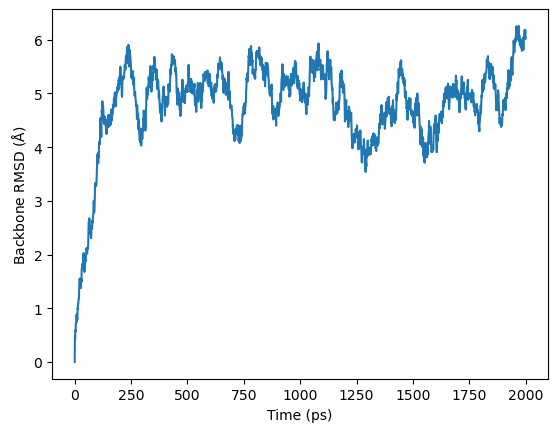

In [12]:
import matplotlib.pyplot as plt

time = np.loadtxt("NPT.txt", usecols=(0,), delimiter=",")
time -= time[0]
rmsd = pt.rmsd(traj, mask="@P,O3',O5',C3',C4',C5'")

plt.plot(time, rmsd)
plt.xlabel("Time (ps)")
plt.ylabel("Backbone RMSD ($\\rm \\AA$)")
plt.show()

### DNA Nucleobase Parameters

![image](helical_parameters.jpg)

The DNA nucleobase parameters can be determined and they can be plotted as a function of time. Below the values are displayed for the middle base pair and base steps.

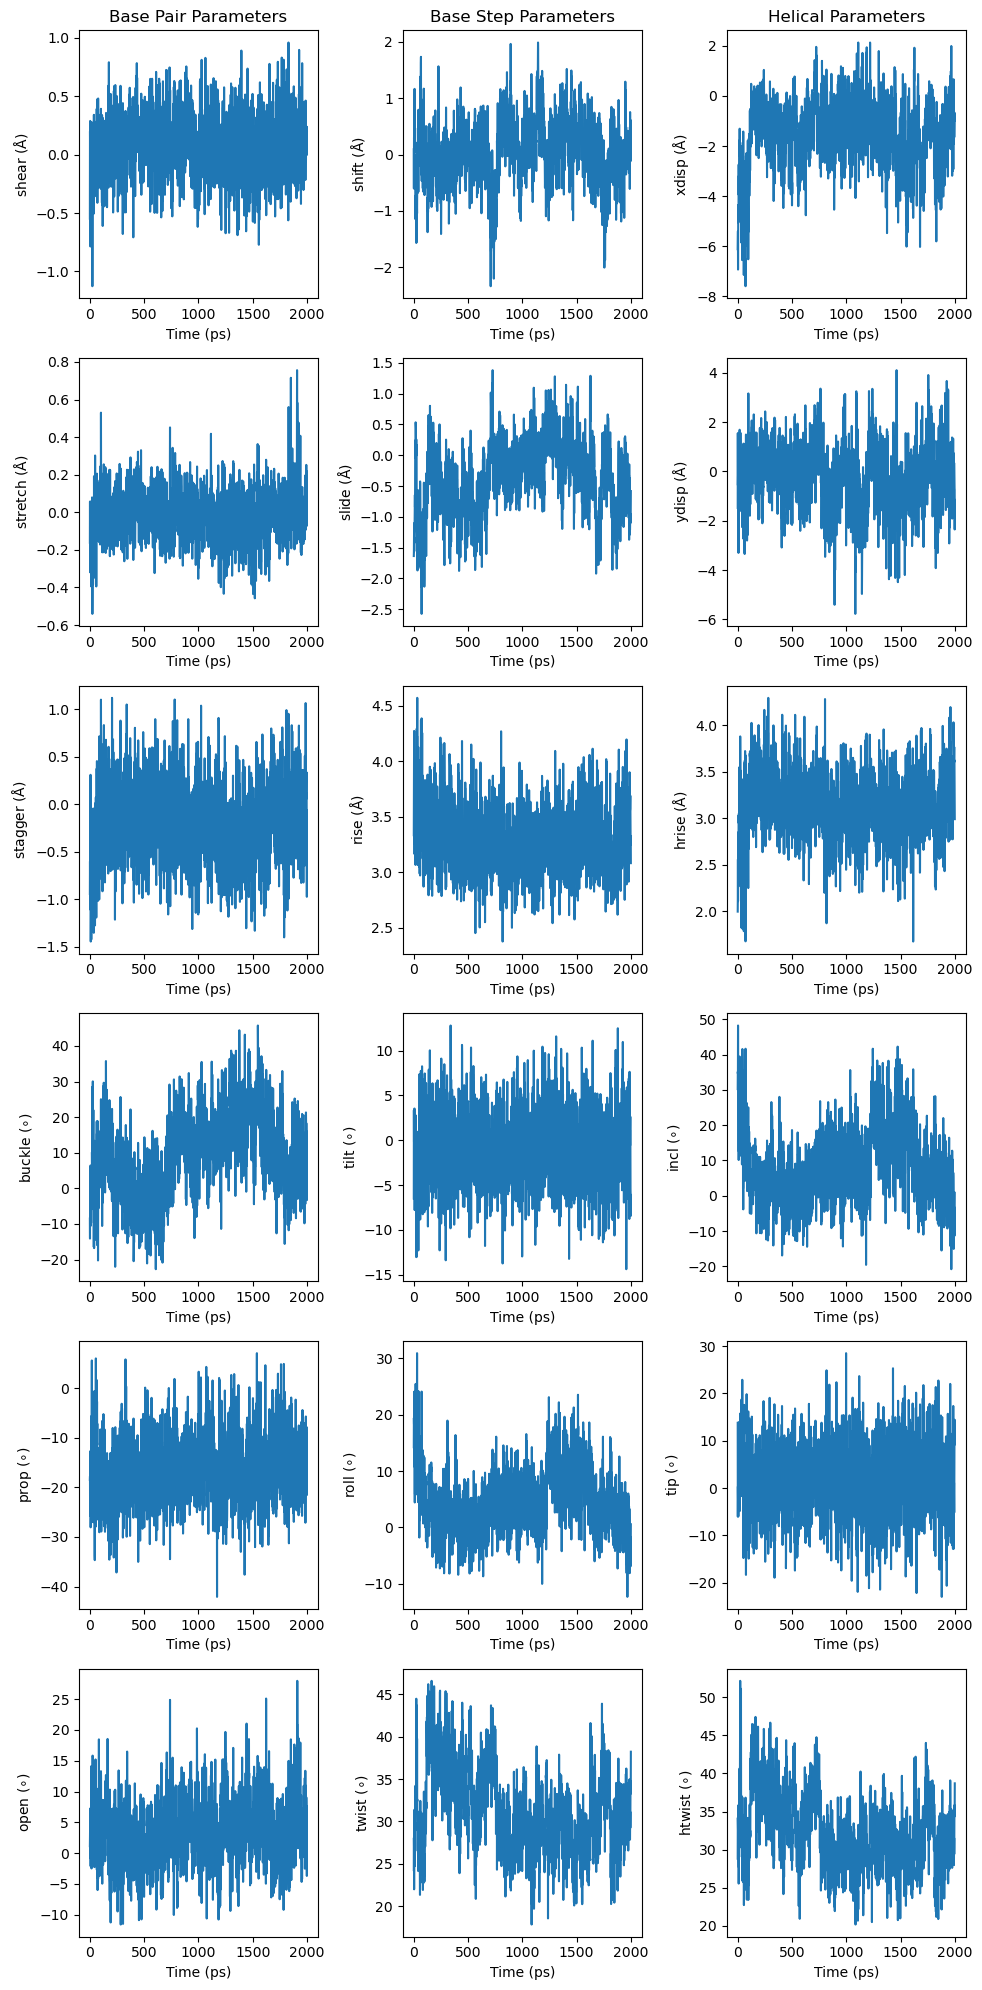

In [7]:
out = pt.nastruct(traj)
fig, axs = plt.subplots(6, 3)
fig.set_figwidth(10)
fig.set_figheight(20)

base_pair = ['shear', 'stretch', 'stagger', 'buckle', 'prop', 'open']
units = ["$\\rm \\AA$", "$\\rm \\AA$", "$\\rm \\AA$", "$\\circ$", "$\\circ$", "$\\circ$"]
for i in range(6):
    if i == 0:
        axs[i, 0].set_title("Base Pair Parameters")
    axs[i, 0].plot(out[base_pair[i]][1][:, 5])
    axs[i, 0].set_xlabel("Time (ps)")
    axs[i, 0].set_ylabel(base_pair[i] + " (%s)" %units[i])

base_step = ['shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
for i in range(6):
    if i == 0:
        axs[i, 1].set_title("Base Step Parameters")
    axs[i, 1].plot(out[base_step[i]][1][:, 5])
    axs[i, 1].set_xlabel("Time (ps)")
    axs[i, 1].set_ylabel(base_step[i] + " (%s)" %units[i])

helical = ['xdisp', 'ydisp', 'hrise', 'incl', 'tip', 'htwist']
for i in range(6):
    if i == 0:
        axs[i, 2].set_title("Helical Parameters")
    axs[i, 2].plot(out[helical[i]][1][:, 5])
    axs[i, 2].set_xlabel("Time (ps)")
    axs[i, 2].set_ylabel(helical[i] + " (%s)" %units[i])

fig.tight_layout()
plt.show()

It should be noted that most parameters show significant fluctuations. This is expected since the simulation is performed at 300 K. These fluctuations do not compromise base pairing and the DNA duplex structure.

The base pair parameters generally average to zero. A notable exception is propeller twist, which is generally around $\sim 20^\circ$. The bases in a base pair are not co-planar, but rather the bases are twisted relative to one another with respect to the hydrogen bond axis.

Some base step and helical parameters change significantly as the DNA changes from the A-form to the B-form although the fluctuations can obscure this. In particular, a specific set of base step and helical parameters distinguish the A-form from the B-form. For the base step parameters, the A-form generally has significant slide and roll. For the helical parameters, the A-form displays sizable x-displacement and inclination. Additionally, the A-form has a lower helical rise. These parameters lead to the short and wide form of A-DNA.